In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

# 讀取資料
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 備份 PassengerId 以供輸出
passenger_ids = test_df["PassengerId"]

# 加上標記以便合併資料做前處理
train_df["is_train"] = 1
test_df["is_train"] = 0
test_df["Transported"] = np.nan # 為 test_df 增加 Transported 欄位，方便合併
combined = pd.concat([train_df, test_df], sort=False)

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 讀取資料並提取 GroupId
train_df = pd.read_csv("train.csv")
train_df['GroupId'] = train_df['PassengerId'].str.split("_").str[0]

print("=== GroupId 基本統計 ===")
print(f"總資料筆數: {len(train_df)}")
print(f"不重複的 GroupId 數量: {train_df['GroupId'].nunique()}")
print(f"平均每個群組人數: {len(train_df) / train_df['GroupId'].nunique():.2f}")

# 群組大小分布
group_sizes = train_df.groupby('GroupId').size()
print("\n=== 群組大小分布 ===")
print(group_sizes.value_counts().sort_index())

=== GroupId 基本統計 ===
總資料筆數: 8693
不重複的 GroupId 數量: 6217
平均每個群組人數: 1.40

=== 群組大小分布 ===
1    4805
2     841
3     340
4     103
5      53
6      29
7      33
8      13
Name: count, dtype: int64


In [19]:
print("\n=== GroupId 與 HomePlanet 關聯性分析 ===")

# 檢查每個群組內 HomePlanet 的一致性
homeplanet_consistency = train_df.groupby('GroupId')['HomePlanet'].agg(['nunique', 'count'])
homeplanet_consistency['is_consistent'] = homeplanet_consistency['nunique'] == 1

print("HomePlanet 在群組內的一致性:")
print(f"完全一致的群組: {homeplanet_consistency['is_consistent'].sum()} / {len(homeplanet_consistency)}")
print(f"一致率: {homeplanet_consistency['is_consistent'].mean():.3f}")

# 查看不一致的群組
inconsistent_groups = homeplanet_consistency[homeplanet_consistency['nunique'] > 1]
print(f"不一致的群組數量: {len(inconsistent_groups)}")


=== GroupId 與 HomePlanet 關聯性分析 ===
HomePlanet 在群組內的一致性:
完全一致的群組: 6107 / 6217
一致率: 0.982
不一致的群組數量: 0


In [20]:
print("\n=== GroupId 與 Cabin 關聯性分析 ===")

# 提取 Cabin 的 Deck 部分進行分析
train_df['Deck'] = train_df['Cabin'].str.split('/').str[0]

# 檢查每個群組內 Deck 的一致性
deck_consistency = train_df.groupby('GroupId')['Deck'].agg(['nunique', 'count'])
deck_consistency['is_consistent'] = deck_consistency['nunique'] == 1

print("Deck 在群組內的一致性:")
print(f"完全一致的群組: {deck_consistency['is_consistent'].sum()} / {len(deck_consistency)}")
print(f"一致率: {deck_consistency['is_consistent'].mean():.3f}")


=== GroupId 與 Cabin 關聯性分析 ===
Deck 在群組內的一致性:
完全一致的群組: 5697 / 6217
一致率: 0.916


In [21]:
# --- 特徵工程 ---
# 乘客編號類似 0001_01，這邊透過 GroupId 判定是否同一家庭或同行者。
combined['GroupId'] = combined['PassengerId'].str.split("_").str[0]

# 填補 HomePlanet 和 Cabin 的缺失值，基於 GroupId
combined['HomePlanet'] = combined.groupby('GroupId')['HomePlanet'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
)
combined['Cabin'] = combined.groupby('GroupId')['Cabin'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
)

In [22]:
# --- 處理缺失的消費欄位，基於 CryoSleep ---
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# 確保 CryoSleep 是字串類型，先填補缺失值
combined['CryoSleep'] = combined['CryoSleep'].fillna('False').astype(str)
for col in spending_columns:
    combined[col] = combined.apply(
        lambda row: 0 if row['CryoSleep'] == 'True' and pd.isna(row[col]) else 
        row[col] if not pd.isna(row[col]) else 
        combined[col].median(), axis=1
    )

c:\Users\Henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


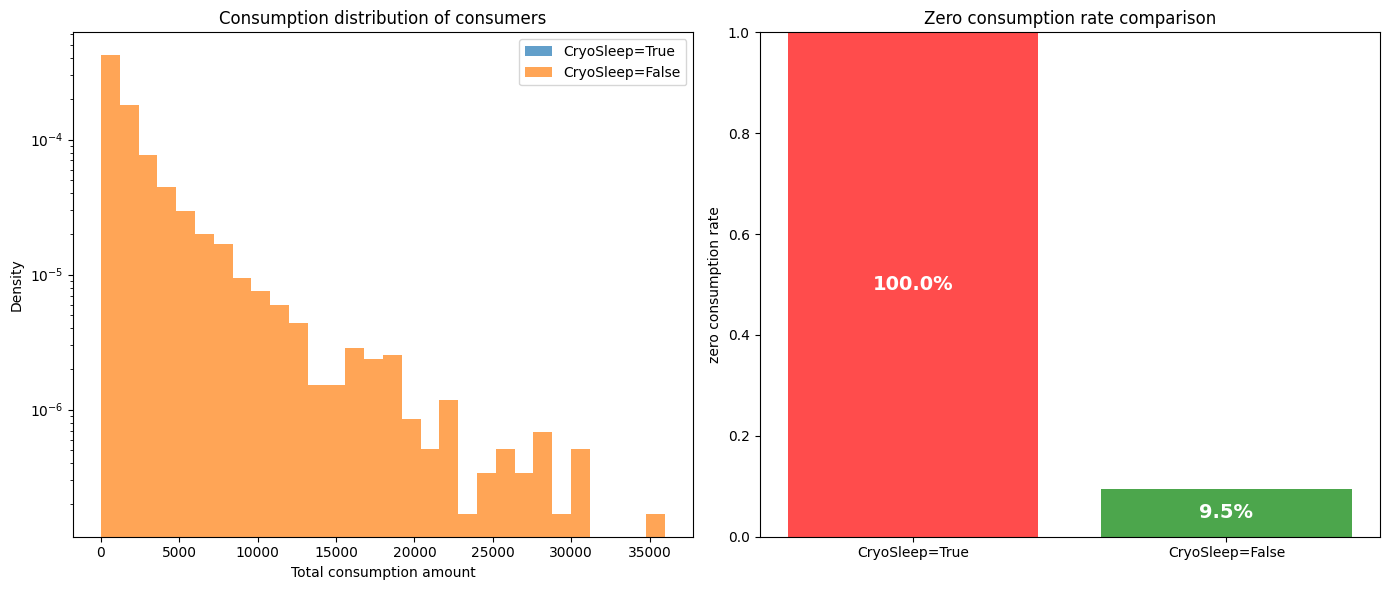

In [23]:
import matplotlib.pyplot as plt

# 計算必要的統計量
train_df['TotalSpending'] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
true_zero_rate = (train_df[train_df['CryoSleep'] == True]['TotalSpending'] == 0).mean()
false_zero_rate = (train_df[train_df['CryoSleep'] == False]['TotalSpending'] == 0).mean()

# 建立有說服力的對比圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 左圖：消費分布對比
for status in [True, False]:
    data = train_df[train_df['CryoSleep'] == status]['TotalSpending']
    data_nonzero = data[data > 0]  # 只看有消費的
    
    ax1.hist(data_nonzero, bins=30, alpha=0.7, 
             label=f'CryoSleep={status}', 
             density=True)

ax1.set_xlabel('Total consumption amount')
ax1.set_ylabel('Density')
ax1.set_title('Consumption distribution of consumers')
ax1.legend()
ax1.set_yscale('log')

# 右圖：零消費率對比
categories = ['CryoSleep=True', 'CryoSleep=False']
zero_rates = [true_zero_rate, false_zero_rate]
colors = ['red', 'green']

bars = ax2.bar(categories, zero_rates, color=colors, alpha=0.7)
ax2.set_ylabel('zero consumption rate')
ax2.set_title('Zero consumption rate comparison')
ax2.set_ylim(0, 1)

# 在柱狀圖上標註數值（放在柱子內部）
for i, (bar, rate) in enumerate(zip(bars, zero_rates)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
             f'{rate:.1%}', ha='center', va='center', 
             fontsize=14, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

In [24]:
cryosleep_true = train_df[train_df['CryoSleep'] == True]
cryosleep_false = train_df[train_df['CryoSleep'] == False]
print("\n=== 結論 ===")
cryosleep_true_zero_rate = (cryosleep_true['TotalSpending'] == 0).mean()
cryosleep_false_zero_rate = (cryosleep_false['TotalSpending'] == 0).mean()

print(f"CryoSleep=True 的乘客有 {cryosleep_true_zero_rate:.1%} 在所有消費項目都花費 0 元")
print(f"CryoSleep=False 的乘客僅有 {cryosleep_false_zero_rate:.1%} 在所有消費項目都花費 0 元")
print(f"兩者差異達 {(cryosleep_true_zero_rate - cryosleep_false_zero_rate):.1%}")


=== 結論 ===
CryoSleep=True 的乘客有 100.0% 在所有消費項目都花費 0 元
CryoSleep=False 的乘客僅有 9.5% 在所有消費項目都花費 0 元
兩者差異達 90.5%


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 讀取資料
train_df = pd.read_csv("train.csv")

print("=== VIP 欄位基本分析 ===")
print("VIP 原始資料類型:", train_df['VIP'].dtype)
print("VIP 值分布:")
print(train_df['VIP'].value_counts(dropna=False))
print(f"VIP 缺失率: {train_df['VIP'].isna().mean():.3f}")

# 檢查獨特值
print(f"\nVIP 獨特值: {train_df['VIP'].unique()}")

=== VIP 欄位基本分析 ===
VIP 原始資料類型: object
VIP 值分布:
VIP
False    8291
NaN       203
True      199
Name: count, dtype: int64
VIP 缺失率: 0.023

VIP 獨特值: [False True nan]


In [26]:
# --- 從 Cabin 提取特徵 ---
combined[["Deck", "CabinNum", "Side"]] = combined["Cabin"].str.split("/", expand=True)
combined["CabinNum"] = pd.to_numeric(combined["CabinNum"], errors='coerce')

# --- 計算 TotalSpend ---
combined["TotalSpend"] = combined[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

# --- 處理 VIP 欄位，統一為字串 ---
combined['VIP'] = combined['VIP'].fillna('False').astype(str)  # 直接填補為字串 'False'，不再轉為布林值

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 讀取資料
train_df = pd.read_csv("train.csv")
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# 先創建 TotalSpend 欄位
train_df["TotalSpend"] = train_df[spending_columns].sum(axis=1)

print("\n=== 預測力比較：為什麼需要 TotalSpend ===")

# 計算每個消費項目與 Transported 的相關性
correlations = {}
for col in spending_columns:
    corr = train_df[col].corr(train_df['Transported'])
    correlations[col] = corr
    print(f"{col} vs Transported: {corr:.4f}")

# TotalSpend 的相關性
total_corr = train_df['TotalSpend'].corr(train_df['Transported'])
correlations['TotalSpend'] = total_corr
print(f"TotalSpend vs Transported: {total_corr:.4f}")

# 找出最強的個別項目
max_individual = max([abs(v) for k, v in correlations.items() if k != 'TotalSpend'])
print(f"\n🔥 關鍵比較:")
print(f"最強個別項目相關性: {max_individual:.4f}")
print(f"TotalSpend 相關性: {abs(total_corr):.4f}")
print(f"TotalSpend 提升: {(abs(total_corr) - max_individual)/max_individual:.1%}")


=== 預測力比較：為什麼需要 TotalSpend ===
RoomService vs Transported: -0.2446
FoodCourt vs Transported: 0.0466
ShoppingMall vs Transported: 0.0101
Spa vs Transported: -0.2211
VRDeck vs Transported: -0.2071
TotalSpend vs Transported: -0.1995

🔥 關鍵比較:
最強個別項目相關性: 0.2446
TotalSpend 相關性: 0.1995
TotalSpend 提升: -18.4%


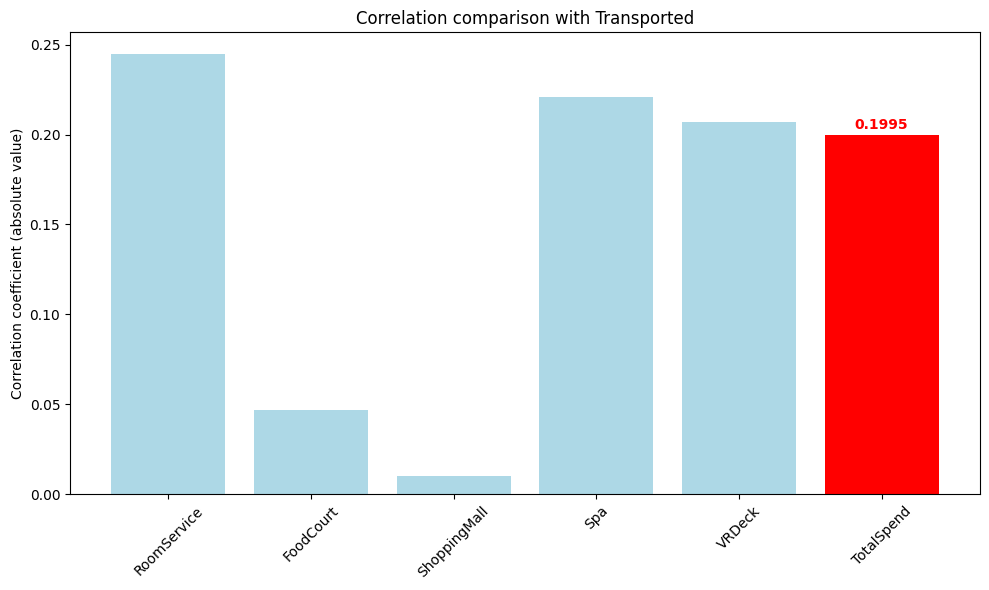

In [28]:
import matplotlib.pyplot as plt

# 右圖：相關性強度比較
plt.figure(figsize=(10, 6))

features = list(correlations.keys())
corr_values = [abs(correlations[f]) for f in features]
colors = ['lightblue'] * (len(features)-1) + ['red']  # TotalSpend 用紅色突出

bars = plt.bar(features, corr_values, color=colors)
plt.title('Correlation comparison with Transported')
plt.ylabel('Correlation coefficient (absolute value)')
plt.xticks(rotation=45)

# 在 TotalSpend 上標註
total_bar = bars[-1]
plt.text(total_bar.get_x() + total_bar.get_width()/2, 
         total_bar.get_height() + 0.002, 
         f'{abs(total_corr):.4f}', 
         ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

In [29]:
# --- 處理其他類別型欄位 ---
combined['CryoSleep'] = combined['CryoSleep'].astype(str)
combined['HomePlanet'] = combined['HomePlanet'].fillna('Unknown').astype(str)
combined['Destination'] = combined['Destination'].fillna('Unknown').astype(str)
combined['Deck'] = combined['Deck'].fillna('Unknown').astype(str)
combined['Side'] = combined['Side'].fillna('Unknown').astype(str)

In [30]:
# --- 確保所有類別欄位為字串型態 ---
categorical_cols = ["HomePlanet", "Destination", "Deck", "Side", "CryoSleep", "VIP"]
#for col in categorical_cols:
    #combined[col] = combined[col].astype(str)  # 強制轉為字串

# --- 數值和類別欄位 ---
numerical_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalSpend", "CabinNum", "GroupSize"]

In [31]:
# --- 創建 GroupSize 特徵 ---
group_size = combined.groupby('GroupId')['PassengerId'].transform('count')
combined['GroupSize'] = group_size

In [ ]:
# --- 建立 Pipeline 進行特徵處理 ---
# 數值型特徵處理：填補中位數並標準化
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 類別型特徵處理：填補 'Missing' 並進行 OneHotEncoder 編碼
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing_Category')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- 處理器 --- 處理特徵並進行OneHot編碼
# 使用 ColumnTransformer 將不同處理方式應用於不同欄位
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # 忽略未指定的欄位
)

# 分割回訓練與測試集
train_processed = combined[combined["is_train"] == 1]
test_processed = combined[combined["is_train"] == 0]

# 特徵欄位與目標欄位
X = train_processed[numerical_cols + categorical_cols]
y = train_processed["Transported"].astype(int)
X_test = test_processed[numerical_cols + categorical_cols]

# --- 整合特徵處理與 Keras 模型訓練 ---
# 在訓練模型前，先處理特徵
X_transformed = preprocessor.fit_transform(X)
X_test_transformed = preprocessor.transform(X_test)

# 建立神經網路模型
model = Sequential()

# 輸入層與第一隱藏層，使用 64 個神經元，並添加 Dropout 層以防止過擬合
model.add(Dense(units=64, input_dim=X_transformed.shape[1], activation='relu'))
model.add(Dropout(0.3))

# 第二隱藏層
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

# 輸出層：二分類問題，使用 sigmoid 激活函數
model.add(Dense(units=1, activation='sigmoid'))

# 編譯模型，使用 Adam 優化器與二元交叉熵損失函數
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
history = model.fit(X_transformed, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 預測測試集
predictions = model.predict(X_test_transformed)
predictions = (predictions > 0.5).astype(int)  # 將機率轉為 0 或 1

# 輸出結果
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Transported": predictions.flatten().astype(bool)  # 確保結果為布林值
})

# 儲存結果
submission_filename = "submission_nn_improved.csv"
submission.to_csv(submission_filename, index=False)
print(f"\n已儲存 {submission_filename}")

Epoch 1/50


c:\Users\Henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6551 - loss: 0.6225 - val_accuracy: 0.7838 - val_loss: 0.4554
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7686 - loss: 0.4699 - val_accuracy: 0.7849 - val_loss: 0.4543
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7849 - loss: 0.4391 - val_accuracy: 0.7855 - val_loss: 0.4458
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7961 - loss: 0.4232 - val_accuracy: 0.7723 - val_loss: 0.4807
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7907 - loss: 0.4238 - val_accuracy: 0.7890 - val_loss: 0.4573
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8015 - loss: 0.4113 - val_accuracy: 0.7665 - val_loss: 0.5059
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8049 - loss: 0.4100 - val_accuracy: 0.7717 - val_loss: 0.4991
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7995 - loss: 0.4001 - val_accuracy: 0.7527 - val_